## Iskanje strukture v podatkih

Podatkovno rudarjenje, naloga, `2.4.2022`  
**`Luka Šveigl`**

Z modeliranjem skušamo poiskati strukturo v podatkih. Z metodami nenadzorovanga modeliranja skušamo poiskati skupine podobnih podatkov oz. skupine primerov.

V nalogi boste uporabili modeliranje verjetnostnih porazdelitev za iskanje osamelcev ter metode za iskanje skupin podobnih primerov (gručenje).

### Podatki

Opis podatkovne zbirke MovieLens ostaja enak prvi nalogi.

### Vprašanja

Z uporabo principov, ki ste jih spoznali na vajah in predavanjih, odgovorite na
spodnja vprašanja. Pri vsakem vprašanju dobro premislite, na kakšen način boste
najbolje podali, prikazali oz. utemeljili odgovor. Bistven del so odgovori na
vprašanja in ne toliko implementacija vaše rešitve.

#### 1. Iskanje osamelcev (50%) 
O ocenah katerih filmov so si uporabniki najmanj enotni? Povedano drugače, za katere filme so pripadajoče ocene najbolj razpršene?

Formuliraj problem kot modeliranje verjetnostne porazdelitve. Premisli o naslednjih vprašanjih, naredi ustrezne poizkuse in odgovori.

In [3]:
import numpy as np
from csv import DictReader

def read_dataset(path):
    reader = DictReader(open(path, 'rt', encoding='utf-8'))
    return reader


Odgovor: **odgovor lahko zapišete v več celic**

#### 1.1. vprašanje:

Katera je ustrezna naključna spremenljivka (količina) v podatkih, ki odgovarja na vprašanje?        

Text(0, 0.5, 'P(X)')

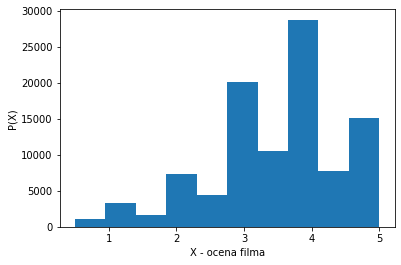

In [4]:
import matplotlib.pyplot as plt

# Create matrix from ratings dataset
npr = np.genfromtxt('podatki/ml-latest-small/ratings.csv', delimiter=',')

# Plot distribution of movie ratings
plt.hist(npr[:, 2], bins=10)
plt.xlabel("X - ocena filma")
plt.ylabel("P(X)")



Vidimo lahko, da je večina ocen povprečnih ali nadpovprečnih, bolj specifično, večina filmov je ocenjenih z 3 ali 4, tako da lahko že ocenimo, da bo porazdelitev približno normalna.

In [5]:
means = dict()
variances = dict()

ratings_per_movie = dict()

for r in npr:
    if np.isnan(r[1]) == False:
        if r[1] in ratings_per_movie:
            ratings_per_movie[r[1]].append(r[2])
        else:
            ratings_per_movie[r[1]] = [r[2]]


for rating in ratings_per_movie.keys():
    if len(ratings_per_movie[rating]) >= 50:
        s = np.mean(ratings_per_movie[rating]) 
        v = np.var(ratings_per_movie[rating])
        means[rating] = s
        variances[rating] = v

 

Odgovor: **Odločil sem se, da bom kot verjetnostno spremenljivko uporabil varianco (Y), saj le ta prikazuje odstopanje podatkov.**

**Vprašanja sem se lotil tako, da sem zbral podatke v slovar, v katerem so ocene grupirane po filmih. Nato sem upošteval le filme, ki imajo 50 ali več ocen, saj čene nimamo**
**dobre podlage za statistično primerjavo.**

#### 1.2. vprašanje:
Nariši njeno porazdelitev, npr., s pomočjo histograma.

Text(0.5, 0, 'Varianca ocene filma (Y)')

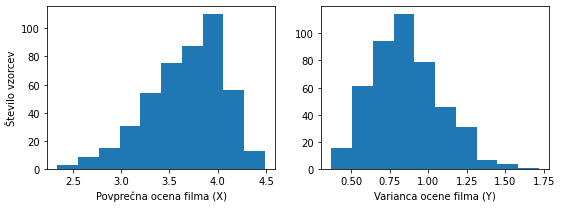

In [6]:
# Display histogram of average movie score
plt.figure(figsize=(9, 3)) 
plt.subplot(1, 2, 1)
plt.hist([v for v in means.values()], density=False, bins=10)
plt.xlabel("Povprečna ocena filma (X)")
plt.ylabel("Število vzorcev")

# Display histogram of movie score variance
plt.subplot(1, 2, 2)
plt.hist([v for v  in variances.values()], density=False, bins=10)
plt.xlabel("Varianca ocene filma (Y)")  

Odgovor: **Vidimo lahko, da je varianca dovolj podobna znanim porazdelitvam.**

#### 1.3. vprašanje:

Ali porazdelitev spominja na kakšno znano porazdelitev? Ali je porazdelitev morda normalna ali katera druga? 

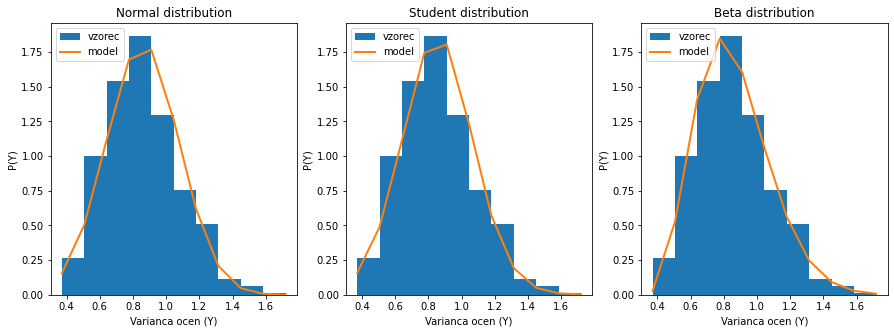

      sumsquare_error        aic          bic    kl_div
beta         0.066593  29.002775 -3973.283585  0.006858
t            0.177272  31.135422 -3535.872737  0.016525
norm         0.183407  30.447499 -3526.576754  0.017102
Best distribution:  {'beta': {'a': 5.695426298524886, 'b': 26.046903277163306, 'loc': 0.2708475391999509, 'scale': 3.2730792975430907}}


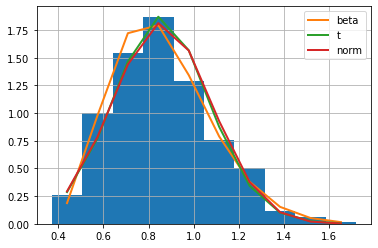

In [7]:
from scipy.stats import multivariate_normal as mvn
from scipy.stats import t as student
from scipy.stats import beta

import warnings
warnings.filterwarnings("ignore")

data = list(variances.values())
n = len(data)

# Normal distribution
# Estimation of values of normal distribution
mu = np.mean(data)
sigma2 = (n - 1) / n * np.var(data)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Normal distribution")
counts, bins, _ = plt.hist(data, density="True", label="vzorec", bins=10)
pdf = [mvn.pdf(x, mu, sigma2) for x in bins]
plt.plot(bins, pdf, "-", label="model", linewidth=2.0)
plt.xlabel("Varianca ocen (Y)")
plt.ylabel("P(Y)")
plt.legend(loc=2)

# Student distribution
# Estimation of values of student distribution
pars = student.fit(data)
P_fit = [student.pdf(x, *pars) for x in bins]

plt.subplot(1, 3, 2)
plt.title("Student distribution")
plt.hist(data, density=True, label="vzorec")
plt.plot(bins, P_fit, "-", label="model", linewidth=2.0)
plt.xlabel("Varianca ocen (Y)")
plt.ylabel("P(Y)")
plt.legend(loc=2)

# Beta distribution
# Estimation of values of beta distribution
pars = beta.fit(data)
P_fit = [beta.pdf(x, *pars) for x in bins]

plt.subplot(1, 3, 3)
plt.title("Beta distribution")
plt.hist(data, density=True, label="vzorec")
plt.plot(bins, P_fit, "-", label="model", linewidth=2.0)
plt.xlabel("Varianca ocen (Y)")
plt.ylabel("P(Y)")
plt.legend(loc=2)

plt.show()

import fitter
f = fitter.Fitter(data, distributions=['beta', 'norm', 't'], bins=10)
f.fit()
print(f.summary())
print("Best distribution: ", f.get_best())

Odgovor: **Čeprav vse 3 porazdelitve zgledajo vredu, sem z uporabo knjižnice fitter ugotovil, da je najboljša porazdelitev beta.**

#### 1.4. vprašanje:

Oceni parametre te porazdelitve s pomočjo postopkov, ki smo jih spoznali na vajah.  Izmed porazdelitev, ki smo jih spoznali na vajah, izberi tisto, ki se podatkom najbolj prilega.        

In [8]:
# Estimation of values of beta distribution
pars = beta.fit(data)
print(pars)


(5.695426298524886, 26.046903277163306, 0.2708475391999509, 3.2730792975430907)


Odgovor: **Parametre porazdelitve (beta) sem ocenil že pri nalogi 1.3, ker sem jih potreboval za izris podatkov.**
**Vrednost a znaša 5.695, b znaša 26.047, loc znaša 0.271 in scale znaša 3.273.**

#### 1.5. vprašanje:

Izpiši filme z vrednostjo naključne spremenljivke, ki spada v zgornjih 5% statistično značilnih primerov. 

In [9]:
movies = read_dataset('podatki/ml-latest-small/movies.csv')

movies_dict = dict()

for movie in movies:
    movies_dict[int(movie['movieId'])] = movie['title']


for key, value in variances.items():
    # Measure we want to evaluate
    qx = value
    
    # Calculate P(x)
    xr = np.linspace(0, 5, len(variances.keys()))
    width = xr[1] - xr[0]
    pars = beta.fit(data)
    #Px = [beta.pdf(x, *pars) * width for x in xr]
    
    # Extract values lower than or equal qx
    ltx = xr[xr >= qx]
    
    # Get area under curve
    P_ltx = [beta.pdf(x, *pars) * width for x in ltx]
    
    # Calculate p-value
    p_value = np.sum(P_ltx)
    alpha = 0.05
    if p_value < alpha:
        print(movies_dict[int(key)], 100 * p_value)

Titanic (1997) 0.5885757391305172
Armageddon (1998) 1.7427786044488063
Star Wars: Episode I - The Phantom Menace (1999) 3.550707142594877
Grumpier Old Men (1995) 3.550707142594877
Dumb & Dumber (Dumb and Dumber) (1994) 3.2600289748419025
Moulin Rouge (2001) 0.9791198791900821
Sling Blade (1996) 2.0948644761099846
Rocky Horror Picture Show, The (1975) 3.550707142594877
Star Wars: Episode II - Attack of the Clones (2002) 0.3446014943976088
Space Jam (1996) 0.5885757391305172
Mission: Impossible II (2000) 3.8633928591616393
English Patient, The (1996) 2.0948644761099846
Starship Troopers (1997) 2.0948644761099846
Cruel Intentions (1999) 0.9791198791900821
South Park: Bigger, Longer and Uncut (1999) 1.4439633310131137
Blair Witch Project, The (1999) 0.06652120891930728
American Psycho (2000) 2.739781465335344
Caddyshack (1980) 4.946460988457083
A.I. Artificial Intelligence (2001) 3.550707142594877


Odgovor: **Izpisoval sem filme, ki imajo p-vrednost manjšo od 0.05, saj tako dobimo filme, ki spadajo v zgornjih 5% statistično značilnih primerov.**

#### 2. Gručenje filmov (50%)

Priporočilni sistemi pogosto odkrivajo skupine predmetov (v našem primeru filme), za katere velja visoka medsebojna podobnost.

Poiščite 100 najbolj gledanih filmov. Ali med njimi obstajajo skupine?
Uporabite ustrezen algoritem za gručenje. Na film lahko gledamo kot vektor, kjer je  
število komponent enako številu uporabnikov. 

Vektorji vsebujejo tudi *neznane vrednosti*.
Primer vektorjev za deset filmov prikazuje spodnja tabela.

Algoritme gručenja lahko izvajamo v izvornem prostoru (koordinatni sistem filmi-uporabniki) ali pa filme primerjamo z merami podobnosti, ki smo jih spoznali na vajah. 
Premisli, kateri način je primernejši glede na obliko podatkov.

| x          |Movie                                      | $u_0$ |$u_1$ | $u_2$ | $\cdots$ |
|------------|-------------------------------------------|:-----:|:----:|:------|:--------:|
|$\vec{x_0}$ | Fight Club (1999)                         | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_1}$ | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | ?     | ?    | 2.5   | $\cdots$ |
|$\vec{x_2}$ | Independence Day (a.k.a. ID4) (1996)      | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_3}$ | Dances with  Wolves (1990)                | 4.0   | ?    | ?     | $\cdots$ |
|$\vec{x_4}$ | Fargo (1996)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_5}$ | Speed (1994)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_6}$ | Apollo 13 (1995)                          | ?     | 2.0  | ?     | $\cdots$ |
|$\vec{x_7}$ | Seven (a.k.a. Se7en) (1995)               | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_8}$ | Sixth Sense, The (1999)                   | 3.0   | ?    | 4.0   | $\cdots$ |
|$\vec{x_9}$ | Aladdin (1992)                            | ?     | ?    | ?     | $\cdots$ |
|$\cdots$    | $\cdots$                                  | $\cdots$ | $\cdots$  | $\cdots$ | $\cdots$ |

Pri tem odgovori na naslednja vprašanja.

#### 2.1. vprašanje:

Utemelji izbiro algoritma in mere podobnosti.

In [10]:
import scipy.cluster.hierarchy as sch
import scipy 

ratings = read_dataset('podatki/ml-latest-small/ratings.csv')

movies_dict = dict()
users_list = dict()

# Generate dict of movies:
#   Key -> movie ID
#   Value -> number of reviews pertaining to that movie
#   This is needed to select top 100 most viewed/rated movies
#
# Generate dict of users (people who rated movies):
#   Key -> user ID
#   Value -> list of movie ID and movie's rating
#   This is needed to know which user evaluated which movie
for rating in ratings:
    if rating['userId'] not in users_list:
        users_list[rating['userId']] = [(rating['movieId'], rating['rating'])]
    else:
        if rating['movieId'] not in users_list[rating['userId']]:
            users_list[rating['userId']].append((rating['movieId'], rating['rating']))
        
    if rating['movieId'] in movies_dict:
        movies_dict[rating['movieId']] += 1
    else:
        movies_dict[rating['movieId']] = 1

# Get list of top 100 movie ID's
top_mvs = list(sorted(movies_dict, key=movies_dict.get, reverse=True)[:100])
# Generate a dict of movie ID -> numpy array pairings
top_dict = {k: np.empty(len(users_list.keys())) for k in top_mvs}

# Loop through all movies
for top_mv in top_dict.keys():
    # Loop through all users
    for key in (users_list.keys()):
        # Check if user rated a movie
        if top_mv not in [y[0] for y in users_list[key]]:
            # If user hasn't rated a movie, set NaN value
            top_dict[top_mv][int(key) - 1] = np.nan
        else:
            # If user has rated a movie, set a rating
            ind = [y[0] for y in users_list[key]].index(top_mv)
            top_dict[top_mv][int(key) - 1] = float(users_list[key][ind][1])

data = list(top_dict.values()) 

# Calculate linkage of movie scores, based on jaccard's method
L = sch.linkage(np.nan_to_num(data, nan=0.0), method='average', metric='jaccard', optimal_ordering=True)

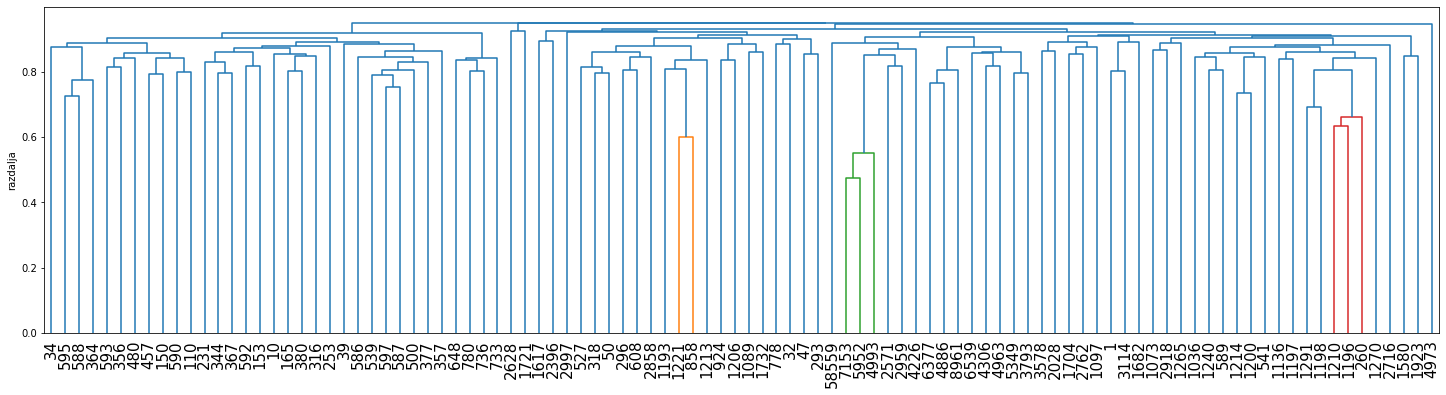

In [11]:
import matplotlib.pyplot as plt

# Display dendrogram of hierarchical clustering
plt.figure(figsize=(25, 6))
labels = [movieId for movieId in top_dict.keys()]
D = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel('razdalja')
plt.show()

Odgovor: **Odločil sem se, da bom pri tej nalogi uporabil hierarhično razvrščanje, saj deluje z vektorskimi podatki in števila skupin ni potrebno podati. Prav tako je hierarhično razvrščanje primerno, saj nimamo preveč primerov. Za mero podobnosti sem izbral Jaccardov indeks, saj je primeren ker vrne podobnost med dvema setoma podatkov.**

#### 2.2. vprašanje:

Koliko skupin filmov je med izbranimi? Ali poznamo kvantitativne ocene za različne možnosti razvrščanja v skupine?

In [24]:
from sklearn.metrics import silhouette_score

# Ignore warnings thrown in library functions
import warnings
warnings.filterwarnings("ignore")

scores = dict()

# Distance where we cut the dendrogram
t = 0

# Loop and increase t value, to find the best silhouette score possible
while t < 1:
    # Get predictions
    predictions = sch.fcluster(L, t=t, criterion='distance').ravel()
    # Exclude predictions if set of clusters too high or small
    if len(set(predictions)) < 100 and len(set(predictions)) >= 2:
        # Calculate silhouette score and add to scores dict
        scores[t] = silhouette_score(np.nan_to_num(data, nan=0.0), predictions, metric='jaccard')
    # Increase t value
    t += 0.001
    
# Get key (t value) with best silhouette score
ms = max(scores, key=scores.get)
print("t value: ", ms, "; silhouette score: ", scores[ms])

t = ms

print("Number of results of fcluster: ", len(sch.fcluster(L, t=t, criterion='distance').ravel()))
print("Number of unique clusters: ", len(set(sch.fcluster(L, t=t, criterion='distance').ravel())))


t value:  0.9480000000000007 ; silhouette score:  0.11170094233911812
Number of results of fcluster:  100
Number of unique clusters:  2


Odgovor: **Kot kvantitativno oceno sem pri tem vprašanju izbral koeficient silhuete. Naloge sem se lotil tako, da sem v zanki povečeval vrednost t, na vsakem koraku izračunal koeficient silhuete, in njegovo vrednost shranil v slovar. To sem naredil zato, da sem pridobil najboljši možen koeficient silhuete, ki je v mojem primeru 0.111, ta metoda pa je ugotovila, da so podatki najbolje gručani, če so razdeljeni v 2 gruči.**

#### 2.3. vprašanje:

Prikaži rezultate z uporabo ustrezne vizualizacije.

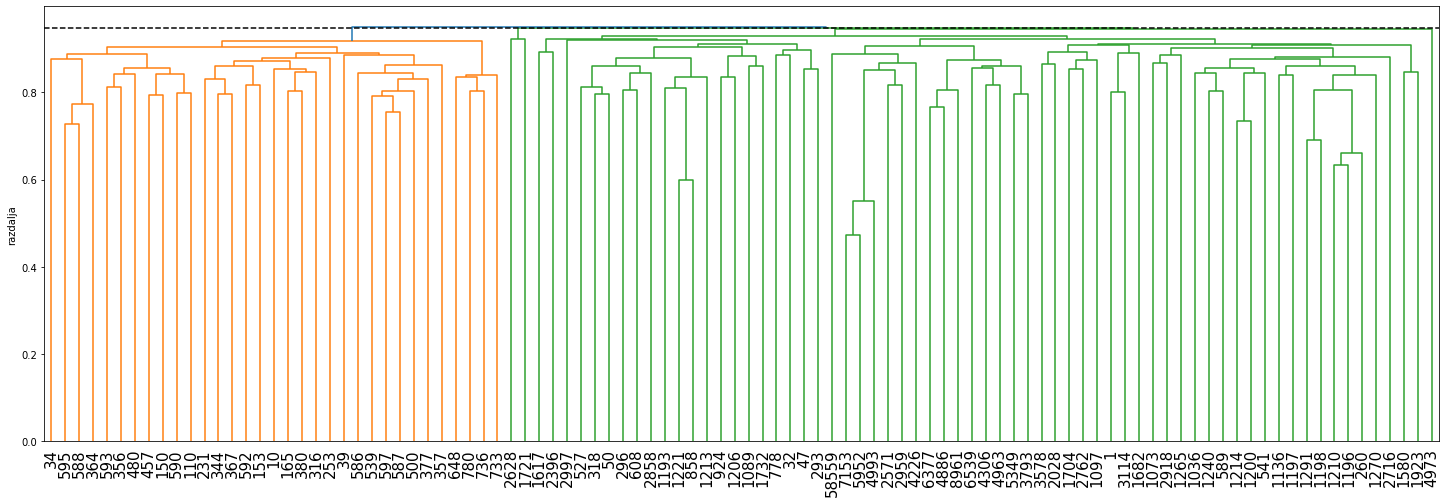

In [16]:
import matplotlib.pyplot as plt

# Display dendrogram again, this time showing where it's cut
plt.figure(figsize=(25, 8))
labels = [movieId for movieId in top_dict.keys()]
D = sch.dendrogram(L, labels=labels, leaf_font_size=15, color_threshold=t)
plt.plot([0, 1000], [t, t], "k--")
plt.ylabel('razdalja')
plt.show()

Odgovor: **Na tej sliki zopet vidimo dendrogram, tokrat z prekinjeno črto, ki prikazuje, pri kateri razdalji smo ga rezali.**

#### 2.4. vprašanje:

Komentiraj smiselnost dobljenih rezultatov.

In [17]:
# kodo lahko razdelite v več celic

Odgovor: **Skozi vprašanja sem prišel do rezultatov, da je najbolše možno gručanje v 2 skupini, in sicer z koeficientom silhuete = 0.111. Ker je koeficient silhuete blizu vrednosti 0, to pomeni da gruče niso razdeljene narobe, hkrati pa tudi, da razdalja med gručami ni pomembna oz. jih je premalo, ali pa da se gruče prekrivajo. Ta rezultat se mi zdi smiselen, saj smo v ocenjevanje vzeli 100 najbolj gledanih filmov, kar pa pomeni, da so si po ocenah zelo podobni, saj so ponavadi bolj gledani filmi boljši. Zato se mi torej zdi smiselno, da je med temi filmi več prekrivanja, kot bi ga bilo če bi upoštevali tudi manj gledane filme.**